# Latency Comparison

In this section we collect results from measuring the latency between ingesting data from the source and collecting the data from the broker (i.e., Kafka vs NGSI-LD Broker).

First, execute the tests from Apache NiFi for each number of events to be sent to the broker every second. The results from these tests will be stored in `results/latency/<broker>/`.

## Building the Datasets

In [5]:
import pandas as pd

#Disable scientific notation in datasets
pd.set_option('display.float_format', lambda x: '%.4f' % x)

Set list with number events per second configured for each experiment.

In [6]:
events = [50,100,200,500,1000]

### Scorpio

In [7]:
import glob

scorpio = []
for event in events:
    path = r'./results/latency/scorpio/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    scorpio.append(pd.concat(li, axis=0, ignore_index=True))
    
# Estimate the delta between the collection and notification timestamps
scorpio_means = []
for table in scorpio:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    scorpio_means.append(table["deltaTimestamp"].mean())

### Orion-LD

In [8]:
import glob

orion = []
for event in events:
    path = r'./results/latency/fiware-orion/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    orion.append(pd.concat(li, axis=0, ignore_index=True))
    
# Estimate the delta between the collection and notification timestamps
orion_means = []
for table in orion:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    orion_means.append(table["deltaTimestamp"].mean())

### Kafka-AVRO

In [9]:
import glob

kafka_avro = []
for event in events:
    path = r'./results/latency/kafka-avro/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    kafka_avro.append(pd.concat(li, axis=0, ignore_index=True))

# Estimate the delta between the collection and notification timestamps
kafka_avro_means = []
for table in kafka_avro:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    kafka_avro_means.append(table["deltaTimestamp"].mean())

### Kafka-NGSI-LD

In [10]:
import glob

kafka_ngsi_ld = []
for event in events:
    path = r'./results/latency/kafka-ngsi-ld/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    kafka_ngsi_ld.append(pd.concat(li, axis=0, ignore_index=True))

# Estimate the delta between the collection and notification timestamps
kafka_ngsi_ld_means = []
for table in kafka_ngsi_ld:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    kafka_ngsi_ld_means.append(table["deltaTimestamp"].mean())

## Visualization

Once the datasets haven prepared, move on to creating some plots.

In [11]:
import matplotlib.pyplot as plt
plt.close("all")

,Events,Kafka-AVRO
0,50,572.1868
1,100,586.1209
2,200,581.9034
3,500,631.6066
4,1000,748.6454


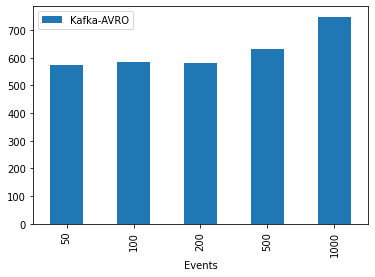

In [12]:

latency = pd.DataFrame({"Events": events,
                       "Kafka-AVRO": kafka_avro_means})
latency.plot.bar(x="Events", logy=False)
latency

,Events,Orion-LD,Scorpio,Kafka-AVRO,Kafka-NGSI-LD
0,50,128.1170,206.5638,572.1868,537.4713
1,100,173.6202,281.5921,586.1209,540.7738
2,200,295.0969,13485.0493,581.9034,541.9778
3,500,31410.0055,54216.9112,631.6066,578.0237
4,1000,45293.2354,34524.3336,748.6454,639.1002


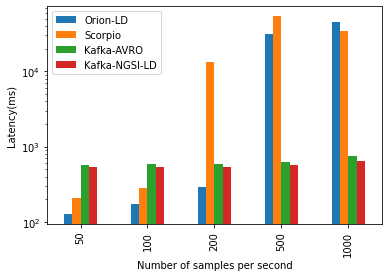

In [47]:
latency = pd.DataFrame({"Events": events,"Orion-LD": orion_means,
                       "Scorpio": scorpio_means, 
                       "Kafka-AVRO": kafka_avro_means,
                       "Kafka-NGSI-LD": kafka_ngsi_ld_means, })
latency_plot = latency.plot.bar(x="Events", logy=True)
latency_plot.set_xlabel("Number of samples per second")
latency_plot.set_ylabel("Latency(ms)")

latency

Text(0, 0.5, 'Latency(ms)')

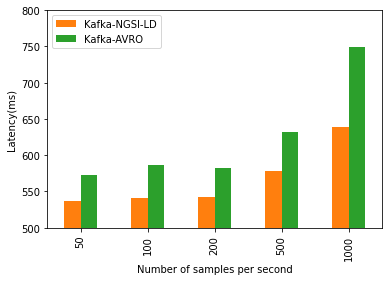

In [46]:
latency_kafka = pd.DataFrame({"Events": events,
                              "Kafka-NGSI-LD": kafka_ngsi_ld_means, 
                              "Kafka-AVRO": kafka_avro_means })
colors = ['tab:orange','tab:green']
latency_kafka_plot = latency_kafka.plot.bar(x="Events", ylim=(500,800), color=colors)
latency_kafka_plot.set_xlabel("Number of samples per second")
latency_kafka_plot.set_ylabel("Latency(ms)")

# Container Performance

The following snippet produces docker stats and appends the results to a CSV file. For these validation tests, we collect the memory and CPU percentage usage:

```bash
while true; do docker stats <my_container> --no-stream --format "{{ .CPUPerc }},{{ .MemPerc }}" | tee --append results/cpu_memory/<my_container>/<my_container>_<events>.csv; sleep 1; done

while true; do docker stats db-mongo fiware-orion nifi --no-stream --format "{{ .Name }},{{ .CPUPerc }},{{ .MemPerc }}" | tee --append results/cpu_memory/orion/orion_50.csv; sleep 1; done
```

We collect results for each NGSI-LD Broker and for Kafka while running the latency tests. Make sure to specify the `events` value used for the latency tests.

You can also use the `collect_docker_stats.sh` utility. The following example collects CPU and memory percentage usage stats for kafka when 60 events are sent every second:

```bash
./collect_docker_stats.sh kafka 60
```

## Building the Datasets

Process the generated CSV files using panda. First remove the percentage character from the memory and CPU columns. Then generate two charts - memory and CPU - that compare Kafka container against each NGSI-LD Broker container.

### Scorpio

In [15]:
scorpio_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/scorpio/scorpio_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    scorpio_services.append(table)

In [48]:
scorpio_cpu = {}
for table in scorpio_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index == "nifi":
            continue
        if index not in scorpio_cpu:
            scorpio_cpu[index] = []
        scorpio_cpu[index].append(value)

Text(0, 0.5, 'Number of samples per second')

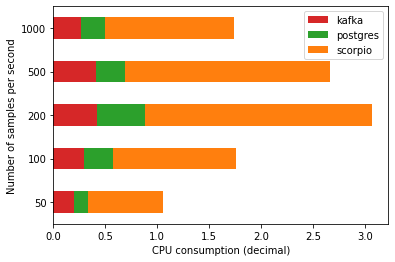

In [79]:
scorpio_cpu_df = pd.DataFrame(scorpio_cpu, index=events)
colors = ['tab:red','tab:green', "tab:orange"]
scorpio_cpu_df_plot = scorpio_cpu_df.plot.barh(stacked=True, color=colors)
scorpio_cpu_df_plot.set_xlabel("CPU consumption (decimal)")
scorpio_cpu_df_plot.set_ylabel("Number of samples per second")

In [75]:
scorpio_mem = {}
for table in scorpio_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index == "nifi":
            continue
        if index not in scorpio_mem:
            scorpio_mem[index] = []
        scorpio_mem[index].append(value)

Text(0, 0.5, 'Number of samples per second')

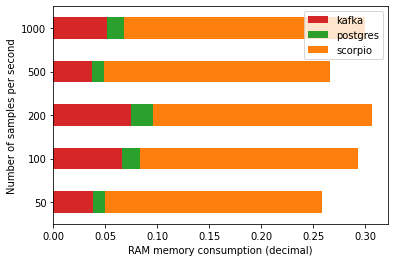

In [80]:
scorpio_mem_df = pd.DataFrame(scorpio_mem, index=events)
colors = ['tab:red','tab:green', "tab:orange"]
scorpio_mem_df_plot = scorpio_mem_df.plot.barh(stacked=True, color=colors)
scorpio_mem_df_plot.set_xlabel("RAM memory consumption (decimal)")
scorpio_mem_df_plot.set_ylabel("Number of samples per second")

### Orion-LD

In [20]:
orion_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/orion/orion_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    orion_services.append(table)

In [52]:
orion_cpu = {}
for table in orion_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index == "nifi":
            continue
        if index not in orion_cpu:
            orion_cpu[index] = []
        orion_cpu[index].append(value)

Text(0, 0.5, 'Number of samples per second')

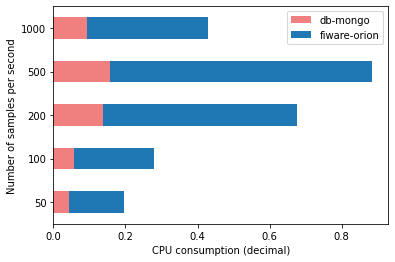

In [82]:
colors = ['lightcoral','tab:blue']
orion_cpu_df = pd.DataFrame(orion_cpu, index=events)
orion_cpu_df_plot = orion_cpu_df.plot.barh(stacked=True, color=colors)
orion_cpu_df_plot.set_xlabel("CPU consumption (decimal)")
orion_cpu_df_plot.set_ylabel("Number of samples per second")

In [54]:
orion_mem = {}
for table in orion_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index == "nifi":
            continue
        if index not in orion_mem:
            orion_mem[index] = []
        orion_mem[index].append(value)

Text(0, 0.5, 'Number of samples per second')

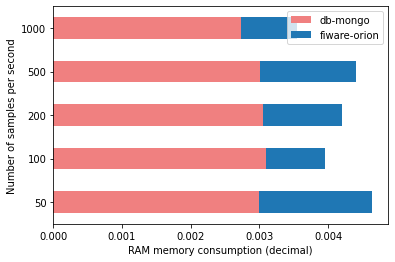

In [83]:
colors = ['lightcoral','tab:blue']
orion_mem_df = pd.DataFrame(orion_mem, index=events)
orion_mem_df_plot = orion_mem_df.plot.barh(stacked=True, color=colors)
orion_mem_df_plot.set_xlabel("RAM memory consumption (decimal)")
orion_mem_df_plot.set_ylabel("Number of samples per second")

### Kafka-AVRO

In [25]:
kafka_avro_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/kafka-avro/kafka-avro_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    kafka_avro_services.append(table)

In [56]:
kafka_avro_cpu = {}
for table in kafka_avro_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index == "nifi":
            continue
        if index not in kafka_avro_cpu:
            kafka_avro_cpu[index] = []
        kafka_avro_cpu[index].append(value)

Text(0, 0.5, 'Number of samples per second')

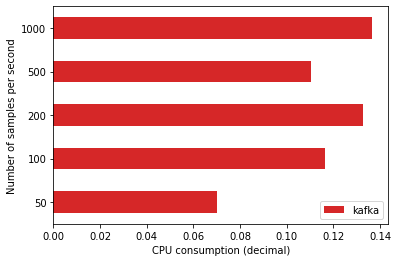

In [84]:
colors = ['tab:red']
kafka_avro_cpu_df = pd.DataFrame(kafka_avro_cpu, index=events)
kafka_avro_cpu_df_plot = kafka_avro_cpu_df.plot.barh(stacked=True, color=colors)
kafka_avro_cpu_df_plot.set_xlabel("CPU consumption (decimal)")
kafka_avro_cpu_df_plot.set_ylabel("Number of samples per second")

In [68]:
kafka_avro_mem = {}
for table in kafka_avro_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index == "nifi":
            continue
        if index not in kafka_avro_mem:
            kafka_avro_mem[index] = []
        kafka_avro_mem[index].append(value)

Text(0, 0.5, 'Number of samples per second')

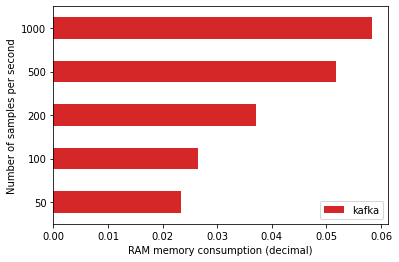

In [85]:
colors = ['tab:red']
kafka_avro_mem_df = pd.DataFrame(kafka_avro_mem, index=events)
kafka_avro_mem_df_plot = kafka_avro_mem_df.plot.barh(stacked=True, color=colors)
kafka_avro_mem_df_plot.set_xlabel("RAM memory consumption (decimal)")
kafka_avro_mem_df_plot.set_ylabel("Number of samples per second")

### Kafka-NGSI-LD

In [60]:
kafka_ngsi_ld_services = []
for event in events:
    dataset_path = r'./results/cpu_memory/kafka-ngsi-ld/kafka-ngsi-ld_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=0, 
                        header=0, names=["service", "cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    kafka_ngsi_ld_services.append(table)

In [61]:
kafka_ngsi_ld_cpu = {}
for table in kafka_ngsi_ld_services:
    cpu_means = table.groupby("service").mean()["cpu"]
    for index,value in cpu_means.iteritems():
        if index == "nifi":
            continue
        if index not in kafka_ngsi_ld_cpu:
            kafka_ngsi_ld_cpu[index] = []
        kafka_ngsi_ld_cpu[index].append(value)

Text(0, 0.5, 'Number of samples per second')

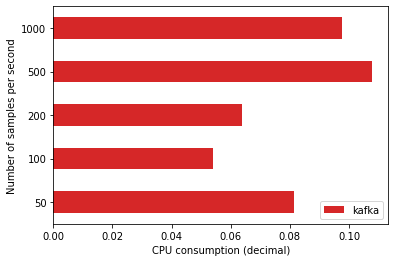

In [87]:
colors = ['tab:red']
kafka_ngsi_ld_cpu_df = pd.DataFrame(kafka_ngsi_ld_cpu, index=events)
kafka_ngsi_ld_cpu_df_plot = kafka_ngsi_ld_cpu_df.plot.barh(stacked=True, color=colors)
kafka_ngsi_ld_cpu_df_plot.set_xlabel("CPU consumption (decimal)")
kafka_ngsi_ld_cpu_df_plot.set_ylabel("Number of samples per second")

In [66]:
kafka_ngsi_ld_mem = {}
for table in kafka_ngsi_ld_services:
    mem_means = table.groupby("service").mean()["memory"]
    for index,value in mem_means.iteritems():
        if index == "nifi":
            continue
        if index not in kafka_ngsi_ld_mem:
            kafka_ngsi_ld_mem[index] = []
        kafka_ngsi_ld_mem[index].append(value)

Text(0, 0.5, 'Number of samples per second')

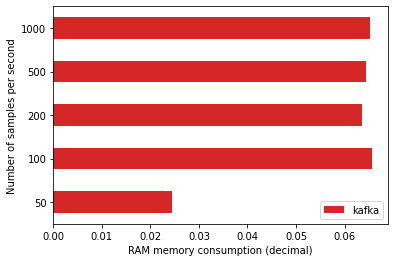

In [86]:
colors = ['tab:red']
kafka_ngsi_ld_mem_df = pd.DataFrame(kafka_ngsi_ld_mem, index=events)
kafka_ngsi_ld_mem_df_plot = kafka_ngsi_ld_mem_df.plot.barh(stacked=True, color=colors)
kafka_ngsi_ld_mem_df_plot.set_xlabel("RAM memory consumption (decimal)")
kafka_ngsi_ld_mem_df_plot.set_ylabel("Number of samples per second")